# 이동평균선
 * 일정 기간동안의 평균을 이동하면서 계산하여 이은 선
 * 5,20,60,120 이 일반적인 기준 
 * 장단기 크로스 포인트 기반의 투자 기법
 * 단기 라인이 장기 라인을 위에서 아래로 뚫었을때 : 매도 타이밍
 * 단기 라인이 장기 라인을 아래서 위로 뚫었을때: 매수 타이밍
 * ? 도대체 몇일 선이 단기라인이고 장기라인인 것인가?
 


In [38]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bsp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

In [39]:
code=271560
pgno=2
url='https://finance.naver.com/item/sise_day.nhn?code={0}&page={1}'
tgurl=url.format(code,pgno)
tgurl

'https://finance.naver.com/item/sise_day.nhn?code=271560&page=2'

In [40]:
def getDB():
    dbname='stockdata.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select * from stockp order by skey asc'
        qry=cur.execute(sql)
        desc=[row[0] for row in qry.description]
        data=qry.fetchall()
    return((desc,data))

In [41]:
res=getDB()
res[0]

['sidx', 'skey', 'sday', 'sopen', 'shigh', 'slow', 'sclose', 'svol']

In [42]:

df=pd.DataFrame(data=res[1],columns=res[0]).set_index('sidx')
df.head()

,skey,sday,sopen,shigh,slow,sclose,svol
sidx,,,,,,,
895,20170707,2017-07-07,87100,89700,75700,82300,1619864
894,20170710,2017-07-10,82300,88000,81000,88000,840451
893,20170711,2017-07-11,88000,88000,82700,82800,422303
892,20170712,2017-07-12,83700,84600,80000,83500,238407
891,20170713,2017-07-13,83400,84000,80800,81600,218138


In [43]:
cdf=df[['sday','sclose']].copy()


In [44]:
cdf.head()

,sday,sclose
sidx,,
895,2017-07-07,82300
894,2017-07-10,88000
893,2017-07-11,82800
892,2017-07-12,83500
891,2017-07-13,81600


In [45]:
def mvline(src=[],mday=5):
    mvdata=[0 for i in range(mday-1)]
    mvdata
    tot =len(src)
    for i in range(tot-mday+1):
        mvm=np.mean(cdf['sclose'][i:mday+i])
        mvdata.append(mvm)
    return (mvdata)

In [46]:
def finprs(df):
    fdf=df.copy()
    precre=0 # 이전 주식 잔고
    predeb=1000000 # 이전 통장 잔고
    prestock=0
    for idx,row in fdf.iterrows():
         # 살수 있는 주식의 갯수
        #단기물 곡선이 하위 포지션에 있다가 장기물 곡선을 크로스 하였다=> 주가 상승 압력이 시작됬다
        # 상승할것으로 보여지니 매수한다.
        if (row.loc['shortpos']==1 and row.loc['shortpos']*row.loc['preshortpos']<0):
            canbuy=predeb//row.loc['sclose']
            if(canbuy>0):
                #산다
                cre=precre+canbuy*row.loc['sclose']
                deb=predeb-canbuy*row.loc['sclose']
                instock=canbuy
            else:# 돈없어서 아무일 없다
                instock=prestock
                cre=precre
                deb=predeb                
        # 단기물 곡선이 상위포지션에 있다가 장기물 곡선을 크로스했다--> 주가의 하방압력이 시작됬다.
        # 하락할것으로 보여지니 매도한다.
        elif (row.loc['shortpos']==-1 and row.loc['shortpos']*row.loc['preshortpos']<0):
            cre=0
            deb=predeb+row.loc['sclose']*prestock
            instock=0
            # sellpos:1 prestock:1,sellpos:-1 prestock:0, no debt
        else:# 조건이 안맞아서 아무일 없다.
            instock=prestock
            cre=precre
            deb=predeb
        fdf.loc[idx,'hasstock']=instock
        fdf.loc[idx,'debt']=deb
        fdf.loc[idx,'credit']=cre
        prestock=instock
        precre=cre
        predeb=deb
    return fdf


In [55]:
def optmv(cdf,sv=5,lv=10):
    cdf['mvshort']=mvline(cdf['sclose'],sv)
    cdf['mvlong']=mvline(cdf['sclose'],lv)
    cdf['shortpos']=np.where(cdf['mvshort']>cdf['mvlong'],1,-1) * np.where(cdf['mvlong']==0,0,1)
    redf=cdf.set_index('sday')
    redf['preshortpos']=redf['shortpos'].shift(1)
    rdf=finprs(redf)
    rdf['totval']=rdf['debt']+rdf['credit']
    lastrow=rdf.iloc[-1:]
    mylastval=lastrow['totval'].values[0]
    return ((sv,lv,mylastval))

In [56]:
result=[]
for sb in range(2,20):
    for lb in range(sb+1,sb+60):
        res=optmv(cdf,sb,lb)
        result.append(res)

In [59]:
vdf= pd.DataFrame(data=result,columns=["short","long","val"])
vdf.tail()

,short,long,val
1057,19,74,1136700.0
1058,19,75,1151200.0
1059,19,76,1135200.0
1060,19,77,1127200.0
1061,19,78,1183000.0


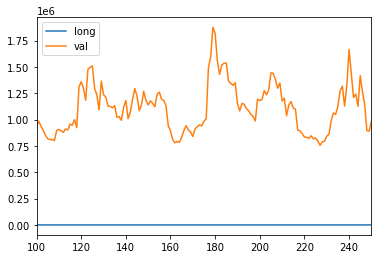

In [64]:
vdf[["long","val"]].plot()
plt.xlim(100,250)
plt.show()

In [62]:
vdf[["val"]].max()
maxrow=vdf.loc[vdf["val"]==1876300.0]
maxrow

,short,long,val
179,5,8,1876300.0


In [53]:
rv=optmv(cdf)

1558500.0